# Bagging Exercises

## Introduction

We will be using the customer churn data from the telecom industry that we used in week 1 for this week's exercises. The data file is called `Orange_Telecom_Churn_Data.csv`. 

In [15]:
from __future__ import print_function
import os
import pandas as pd
import numpy as np
data_path = ['..', '..', 'data']

## Question 1

* Import the customer churn data, which is found in the file `Orange_Telecom_Churn_Data.csv`. 
* Remove any columns that are likely not to be used for prediction.
* Encode data types as appropriate.

In [38]:
data = pd.read_csv('./data/Orange_Telecom_Churn_Data.csv')
data

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,HI,50,408,365-8751,no,yes,40,235.7,127,40.07,...,126,18.96,297.5,116,13.39,9.9,5,2.67,2,False
4996,WV,152,415,334-9736,no,no,0,184.2,90,31.31,...,73,21.83,213.6,113,9.61,14.7,2,3.97,3,True
4997,DC,61,415,333-6861,no,no,0,140.6,89,23.90,...,128,14.69,212.4,97,9.56,13.6,4,3.67,1,False
4998,DC,109,510,394-2206,no,no,0,188.8,67,32.10,...,92,14.59,224.4,89,10.10,8.5,6,2.30,0,False


The prediction should definitely not include phone number. And it is unlikely that area code or state would be desired, unless there is some reason to assume the model has a very specific geographic factor.

In [39]:
#Dropping undesired columns
undesired = ['state', 'area_code', 'phone_number']
data = data.drop(undesired, axis=1)


Examine the data types. Everything looks OK other than `int_plan` and `voice_mail_plan` need to be boolean encoded.

In [46]:
#Examining data types
print(data.dtypes)

#Encode object columns and bool label
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_cols = ['intl_plan', 'voice_mail_plan', 'churned']

data[encoded_cols] = data[encoded_cols].apply(lambda col: le.fit_transform(col))


## Question 2

* Examine distribution of the predicted variable (`churned`).
* Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution.
* Examine the distribution of the predictor variable in the train and test data.

In [75]:
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

#Distribution of churned
print(data.churned.value_counts())

#Separating data from label
X = data.drop('churned', axis=1)
y = data.churned

#StratifiedSplit(bigger difference in classes with SSS)
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, train_size=0.7,  random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

0    4293
1     707
Name: churned, dtype: int64
0    3005
1     495
Name: churned, dtype: int64
0    1288
1     212
Name: churned, dtype: int64


Given the skew in the predictor variable, let's split the data with the *churned* values being stratified.

In [76]:
#Bigger skew with Stratified in training but less in testing
print(y_train.skew())
print(y_test.skew())

2.058899139586524
2.0612043101817368


## Question 3

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [81]:
# Suppress warnings about too few trees from the early models
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [97]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(warm_start=True, oob_score=True)
rfc_errors = {}

for num_trees in range(50, 175):
    rfc.set_params(n_estimators=num_trees)
    rfc.fit(X_train, y_train)
    
    #Store every score for each num_tree
    oob_error = 1 - rfc.oob_score_
    rfc_errors[num_trees] = oob_error

#Prediction
y_pred_rfc = rfc.predict(X_test)

The error looks like it has stabilized around 100-150 trees.

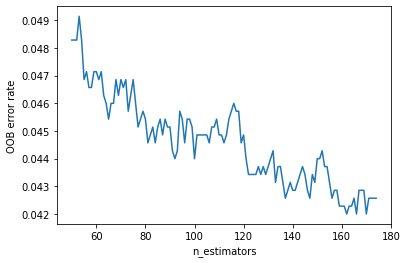

In [87]:
#Plotting the errors
x, y = zip(*rfc_errors.items()) 

plt.plot(x, y)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

## Question 4

* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

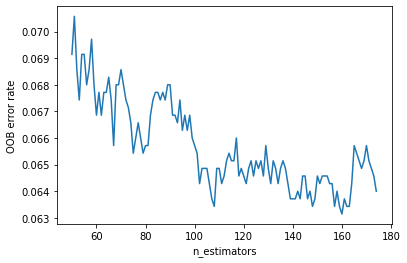

In [98]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(warm_start=True, oob_score=True, bootstrap=True)
etc_errors = {}

for num_trees in range(50, 175):
    etc.set_params(n_estimators=num_trees)
    etc.fit(X_train, y_train)
    
    #Store every score for each num_tree
    oob_error = 1 - etc.oob_score_
    etc_errors[num_trees] = oob_error
    
#Prediction
y_pred_etc = etc.predict(X_test)

x, y = zip(*etc_errors.items()) 

plt.plot(x, y)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

Combine the two dataframes into a single one for easier plotting.

In [94]:
error_dict = {}

#Combine both dictionaries
for key in (rfc_errors.keys() | etc_errors.keys()):
    if key in rfc_errors: error_dict.setdefault(key, []).append(rfc_errors[key])
    if key in etc_errors: error_dict.setdefault(key, []).append(etc_errors[key])

#Create df
error_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=['rfc', 'etc'])
error_df

,rfc,etc
50,0.048286,0.070857
51,0.048286,0.071143
52,0.048286,0.070286
53,0.049143,0.069429
54,0.048286,0.070857
...,...,...
170,0.042000,0.062286
171,0.042571,0.062571
172,0.042571,0.062571
173,0.042571,0.062000


The random forest model performs consistently better than the extra randomized trees.

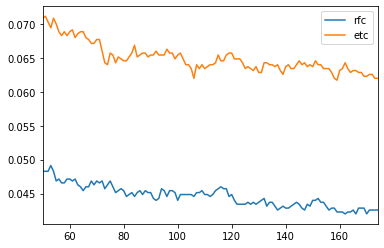

In [96]:
error_df.plot(kind='line');

## Question 5

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [101]:
#Best model as seen above: Random Forest Classifier
#Best Metric: F1
#Deceiving: Accuracy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score


#Using the metrics for Random Forest Classifier
precision, recall, fscore, support = score(y_test, y_pred_rfc)
accuracy = accuracy_score(y_test, y_pred_rfc)
roc_auc = roc_auc_score(y_test, y_pred_rfc)
cfm = confusion_matrix(y_test, y_pred_rfc)

Unsurprisingly, recall is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.932 (vs 0.85 for random guessing).

In [105]:
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F-Score: {fscore}")
print(f"Support Score: {support}")
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")


Precision Score: [0.95945946 0.94047619]
Recall Score: [0.99223602 0.74528302]
F-Score: [0.97557252 0.83157895]
Support Score: [1288  212]
Accuracy Score: 0.9573333333333334
ROC AUC Score: 0.8687595218563225
Confusion matrix:
[[1278   10]
 [  54  158]]


## Question 6

* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

In [120]:
from sklearn.metrics import roc_curve, roc_auc_score

# Print Confusion Matrix
print('Confusion matrix:')
print(cfm)

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfc)
roc_auc = roc_auc_score(y_test, y_pred_rfc)

Confusion matrix:
[[1278   10]
 [  54  158]]


The ROC-AUC and precision-recall curves.

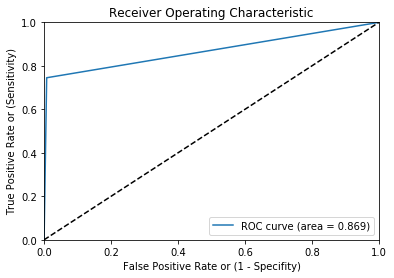

In [119]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc);
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right");

The feature importances. Total daily cost is the biggest predictor of customer churn.

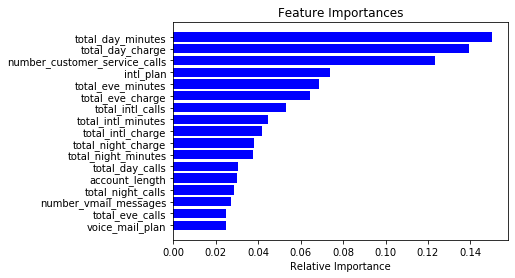

In [136]:
importance = rfc.feature_importances_
features = X.columns
indices = np.argsort(importance)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()